# Trabalho 5 - Transformada de Hough

Faça um documento jupyter notebook que forneça, com base na transformada de Hough modelada para círculos, a contagem e a descrição (coordenadas dos centros e raio) dos discos grandes presentes na imagem do exemplo (do trabalho 3 - segmentação dos discos claros usando a transformada top-hat). 

-------

Procedimento sugerido:

Use como base o resultado do trabalho 3. Inicialmente, subtraia o resultado do trabalho 3 da imagem original a fim de obter a segmentação dos discos. Em seguida, utilize um filtro para obter as bordas dos discos e binarize o resultado. Por fim, empregue a transformada de Hough para obter as informações desejadas.

-------

In [1]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

## Carregando as images

In [34]:
cosmos_entrada = cv.imread('../images/cosmos_original.jpg', 0)
cosmos_saida = cv.imread('../images/img_final.jpg', 0)

In [35]:
cosmos_diff = cosmos_entrada - cosmos_saida

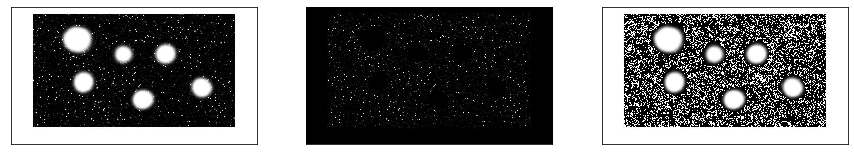

In [37]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 3, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[0, 2])

ax0.imshow(cosmos_entrada, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_saida, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cosmos_diff, cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])



plt.show()

In [38]:
def img2binary(img, threshold = 60):
    """Binarization of image with threshold given"""
    return threshold < img

In [39]:
def roberts(img):
    """Apply Roberts filter to image"""
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsy, -1)))
    
    return robertsx + robertsy

In [ ]:
sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float)

#Calculate gx and gy using Sobel (horizontal and vertical gradients)
gx = cv2.filter2D(image, -1, sobelx)
gy = cv2.filter2D(image, -1, sobely)
#Calculate the gradient magnitude
g = np.sqrt(gx * gx + gy * gy)

#Normalize output to fit the range 0-255
g *= 255.0 / np.max(g)

In [40]:
def binary_roberts(img, threshold = 60):
    """Returns roberts image in binary scale"""
    return img2binary(roberts(img), threshold).astype(np.uint8)

In [69]:
cosmos_test_0 = img2binary(cosmos_diff)
cosmos_test_1 = img2binary(cosmos_diff, 100)
cosmos_test_2 = img2binary(cosmos_diff, 200)

In [70]:
cosmos_rob = roberts(cosmos_test_0.astype(np.uint8))

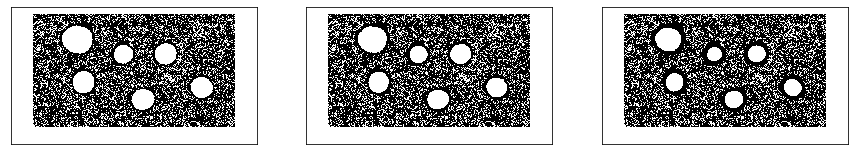

In [62]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 3, fig)

ax0 = fig.add_subplot(grid[0, 0])
ax1 = fig.add_subplot(grid[0, 1])
ax2 = fig.add_subplot(grid[0, 2])

ax0.imshow(cosmos_test_0, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

ax1.imshow(cosmos_test_1, cmap = 'gray')
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(cosmos_test_2, cmap = 'gray')
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()


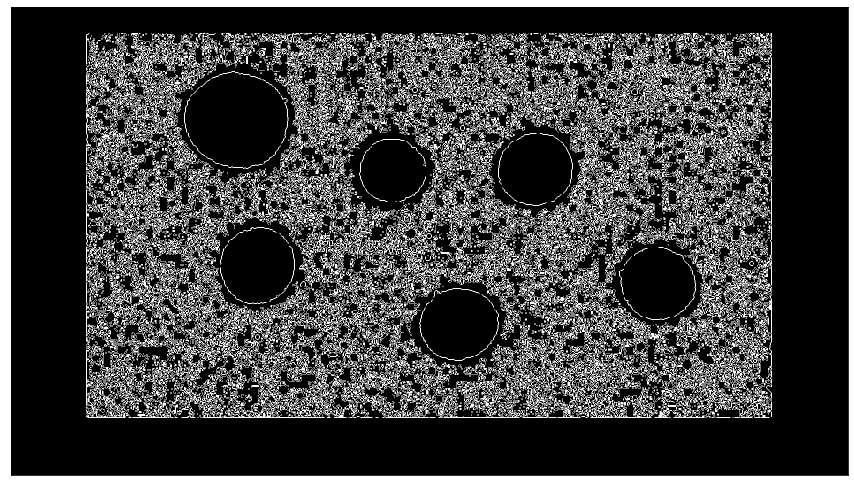

In [71]:
fig = plt.figure(figsize = (15, 9))

grid = plt.GridSpec(1, 1, fig)

ax0 = fig.add_subplot(grid[0, 0])

ax0.imshow(cosmos_rob, cmap = 'gray')
ax0.set_xticks([])
ax0.set_yticks([])

plt.show()